# Introdução

O Poder Judiciário brasileiro enfrenta uma crescente sobrecarga processual. Na Justiça do Trabalho, por exemplo, em 2023 foram iniciados cerca de 4,2 milhões de novos processos (aumento de 28,7\% em relação ao ano anterior) \cite{anamatra2025}. A conciliação atua como uma válvula de escape, com 12\% dos processos resolvidos via acordo, chegando a 36,5\% na Justiça do Trabalho.

Pesquisas recentes demonstram que técnicas de IA e Processamento de Linguagem Natural podem prever desfechos judiciais com acurácia elevada (cerca de 79\% e 75\% em estudos distintos). Esses resultados incentivam a aplicação de tais abordagens para identificar casos com alta probabilidade de conciliação.

Este trabalho propõe a comparação entre abordagens clássicas e Large Language Models (LLM's) para predizer a ocorrência de conciliação em processos trabalhistas no Espírito Santo. Dado um conjunto de informações processuais – incluindo dados das partes, características da causa e textos apresentados –, o objetivo é prever se o caso será resolvido por meio de conciliação ou por sentença judicial.

# Definição do problema

Devido à sobrecarga processual na Justiça do Trabalho, é essencial identificar precocemente se um processo será resolvido por conciliação ou por sentença judicial. Essa previsão auxilia na priorização e alocação dos esforços judiciais, contribuindo para uma resolução mais rápida e eficiente dos conflitos. Sendo o problema abordado prever a partir dos dados de um processo trabalhista, se a resolução ocorrerá via conciliação ou por sentença judicial.

# Descrição do conjunto de dados

A conjunto de dados trabalho reúne informações essenciais para a predição de conciliações em processos trabalhistas no Espírito Santo, organizadas em três categorias principais:

* Identificação e Classificação: Dados que permitem a organização dos casos, como o identificador único do processo e a categoria ou tipo do litígio.
* Características Econômicas e das Partes: Informações relativas ao valor da causa, à natureza das partes (pública ou privada) e à quantidade de reclamantes e reclamados, refletindo a dimensão econômica e a complexidade do processo.
* Temporalidade e Desfecho: Dados referentes às datas de ajuizamento e julgamento, além da variável binária que indica se houve conciliação (1) ou não (0), fundamentais para a análise de padrões temporais e resultados.

Para a análise realizada neste trabalho, foram utilizadas exclusivamente as seguintes características textuais: 
Vara do Trabalho, Ramo de Atividade, Classe Processual, Cidade de Origem da Petição Inicial, OAB, Assuntos, RECDA PES FÍS OU JUR, Portador de Deficiência, Segredo de Justiça, RECDA Ativa-Inativa, Ente Público ou Privado, Indicador do Processo, Documentos das Reclamadas e Documentos dos Reclamantes. 

Adicionalmente, para capturar a evolução temporal dos processos e possíveis tendências associadas às datas de julgamento, os dados foram divididos em janelas móveis baseadas no dia de julgamento. Essa estratégia permite que o modelo seja treinado e testado em intervalos de tempo distintos, sendo cada janela com 2 anos de dados totais e sendo 6 meses de diferença entre elas. 

Em cada janela, os dados foram particionados na proporção de 70\% para treino e 30\% para teste, garantindo uma avaliação robusta e representativa da performance preditiva.

In [18]:
import pandas as pd

In [19]:
df = pd.read_parquet('../data/updated_dataset.parquet.gzip')
df.head(10)

,NÚMERO DO PROCESSO,CLASSE PROCESSUAL,VARA DO TRABALHO,MAGISTRADO,ASSUNTOS,PORTADOR DEFICIÊNCIA,SEGREDO DE JUSTIÇA,RECDA ATIVA-INATIVA,RECDA PES FÍS OU JUR,OAB,...,CIDADE ORIG PET INICIAL,ENTE PUB OU PRIV,INDICADOR DO PROC,QTD RTE,QTD RDO,TIPO DE SOLUÇÃO,DATA DE JULGAMENTO,DATA DE AJUIZAMENTO,DOCUMENTOS DAS RECLAMADAS,DOCUMENTOS DOS RECLAMANTES
0,0000001-03.2016.5.17.0009,ACum - Ação de Cumprimento,VITV09 - 9ª Vara do Trabalho de Vitória ...,LUCY DE FÁTIMA CRUZ LAGO,Honorários Assistenciais; Honorários na Justiç...,N,N,S,J,"13239 - ES, 20032 - ES, 0018277 - ES, 9985 - E...",...,VITORIA - ES,Empresa Individual de Responsabilidade Limitad...,Sem Indicador do Proc,1.0,1.0,Julgados Procedente em parte,2016-10-26 19:38:52,2016-01-04 11:52:19.302,04.249.145/0001-81,32.479.073/0001-02
1,0000001-04.2019.5.17.0007,RTOrd - Ação Trabalhista - Rito Ordinário,VITV07 - 7ª Vara do Trabalho de Vitória ...,FAUSTO SIQUEIRA GAIA,Adicional de Insalubridade; Assistência Judici...,N,N,S,J,"5204 - ES, 20077 - ES",...,CARIACICA - ES,Associação Privada,Sem Indicador do Proc,1.0,1.0,Julgados Improcedente,2019-09-13 11:18:32,2019-01-03 10:58:59.914,28.141.190/0001-86,904.316.187-04
2,0000001-05.2017.5.17.0191,RTOrd - Ação Trabalhista - Rito Ordinário,MATV01 - Vara do Trabalho de São Mateus ...,EZEQUIEL ANDERSON,Anotação / Baixa / Retificação; Ausência de Ju...,N,N,S,"J, J","52308 - PR, 192953 - SP, 207753 - SP, 9985 - E...",...,SAO MATEUS - ES,"Sociedade Empresária Limitada, Sociedade de Ec...",Sem Indicador do Proc,1.0,2.0,Julgados Procedente em parte,2017-09-04 12:57:37,2017-01-02 11:11:45.636,00.277.106/0001-37|33.000.167/0001-01,019.794.547-36
3,0000001-05.2022.5.17.0005,RTSum - Ação Trabalhista - Rito Sumaríssimo,VITV05 - 5ª Vara do Trabalho de Vitória ...,FÁTIMA GOMES FERREIRA,Anotação na CTPS,N,N,S,J,10710 - ES,...,VITORIA - ES,Sociedade Empresária Limitada,Sem Indicador do Proc,1.0,1.0,Julgados Procedente,2022-05-09 16:11:26,2022-01-05 14:56:39.328,17.741.129/0001-53,075.125.376-62
4,0000001-06.2015.5.17.0181,RTOrd - Ação Trabalhista - Rito Ordinário,NVEV01 - Vara do Trabalho de Nova Venécia ...,GEOVANY CARDOSO JEVEAUX,Anotação na CTPS; Piso Salarial da Categoria /...,N,N,S,"J, J",20625 - ES,...,NOVA VENECIA - ES,"Pessoa Jurídica, Pessoa Jurídica",Sem Indicador do Proc,1.0,2.0,Conciliações,2015-03-17 18:53:28,2015-01-05 17:10:11.811,09.248.524/0001-70,136.033.447-58
5,0000001-06.2016.5.17.0008,RTOrd - Ação Trabalhista - Rito Ordinário,VITV08 - 8ª Vara do Trabalho de Vitória ...,NEY ALVARES PIMENTA FILHO,Base de Cálculo; Honorários Assistenciais; Hon...,N,N,S,"J, O","9985 - ES, 13891 - ES, 19519 - ES, 20032 - ES,...",...,VITORIA - ES,"Sociedade Empresária Limitada, Estado ou Distr...",Sem Indicador do Proc,1.0,2.0,Conciliações,2016-05-31 13:42:17,2016-01-04 11:39:11.485,39.299.359/0001-47|27.080.530/0001-43,027.857.687-79
6,0000001-07.2019.5.17.0006,RTOrd - Ação Trabalhista - Rito Ordinário,VITV06 - 6ª Vara do Trabalho de Vitória ...,GUILHERME PIVETI,Adicional de Hora Extra,N,N,S,J,"22973 - ES, 27578 - ES",...,VITORIA - ES,Sociedade Empresária Limitada,Sem Indicador do Proc,1.0,1.0,Conciliações,2019-02-19 14:23:47,2019-01-03 10:12:38.977,30.686.711/0001-22,031.527.297-07
7,0000001-08.2022.5.17.0004,ACum - Ação de Cumprimento,VITV04 - 4ª Vara do Trabalho de Vitória ...,LEONARDO GOMES DE CASTRO PEREIRA,Multa Prevista em Norma Coletiva,N,N,S,"J, O","4327 - ES, 16886 - ES, 17647 - ES, 19519 - ES",...,VITORIA - ES,"Sociedade Empresária Limitada, Estado ou Distr...",Sem Indicador do Proc,1.0,2.0,Julgados Improcedente,2022-07-04 15:33:31,2022-01-06 11:59:13.206,17.330.993/0001-62|27.080.530/0001-43,32.479.073/0001-02
8,0000001-09.2016.5.17.0007,RTOrd - Ação Trabalhista - Rito Ordinário,VITV07 - 7ª Vara do Trabalho de Vitória ...,ANTÔNIO DE CARVALHO PIRES,Anotação / Baixa / Retificação; FGTS; Honorári...,N,N,S,"O, J","0018277 - ES, 19519 - ES, 13891 - ES, 20032 - ...",...,VILA VELHA - ES,"Municípios, Sociedade Empresária Limitada",Sem Indicador do Proc,1

In [20]:
# Informações gerais sobre o dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 261244 entries, 0 to 14612
Data columns (total 22 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   NÚMERO DO PROCESSO          261244 non-null  object        
 1   CLASSE PROCESSUAL           261244 non-null  object        
 2   VARA DO TRABALHO            261244 non-null  object        
 3   MAGISTRADO                  261244 non-null  object        
 4   ASSUNTOS                    261244 non-null  object        
 5   PORTADOR DEFICIÊNCIA        261244 non-null  object        
 6   SEGREDO DE JUSTIÇA          261244 non-null  object        
 7   RECDA ATIVA-INATIVA         261244 non-null  object        
 8   RECDA PES FÍS OU JUR        261244 non-null  object        
 9   OAB                         261244 non-null  object        
 10  VALOR DA CAUSA              261244 non-null  float64       
 11  RAMO DE ATIVIDADE           261244 non-null  

In [21]:
# Colunas presentes
df.columns

Index(['NÚMERO DO PROCESSO', 'CLASSE PROCESSUAL', 'VARA DO TRABALHO',
       'MAGISTRADO', 'ASSUNTOS', 'PORTADOR DEFICIÊNCIA', 'SEGREDO DE JUSTIÇA',
       'RECDA ATIVA-INATIVA', 'RECDA PES FÍS OU JUR', 'OAB', 'VALOR DA CAUSA',
       'RAMO DE ATIVIDADE', 'CIDADE ORIG PET INICIAL', 'ENTE PUB OU PRIV',
       'INDICADOR DO PROC', 'QTD RTE', 'QTD RDO', 'TIPO DE SOLUÇÃO',
       'DATA DE JULGAMENTO', 'DATA DE AJUIZAMENTO',
       'DOCUMENTOS DAS RECLAMADAS', 'DOCUMENTOS DOS RECLAMANTES'],
      dtype='object')

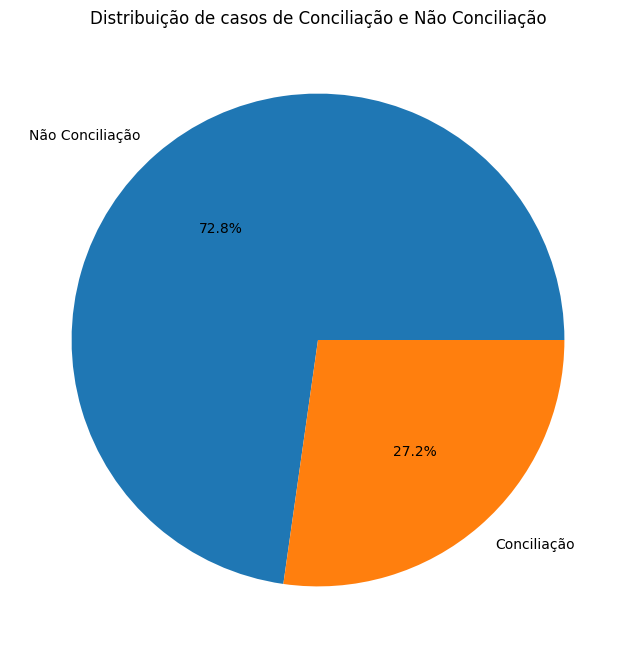

In [22]:
# Quantidade de casos de Conciliação e Não Conciliação
df['label'] = df['TIPO DE SOLUÇÃO'].apply(lambda x: 'Conciliação' if x == 'Conciliações' else 'Não Conciliação')
df['label'].value_counts()
import matplotlib.pyplot as plt

# Create pie chart
plt.figure(figsize=(10, 8))
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribuição de casos de Conciliação e Não Conciliação')
plt.ylabel('')  # Remove y-label for cleaner look
plt.show()

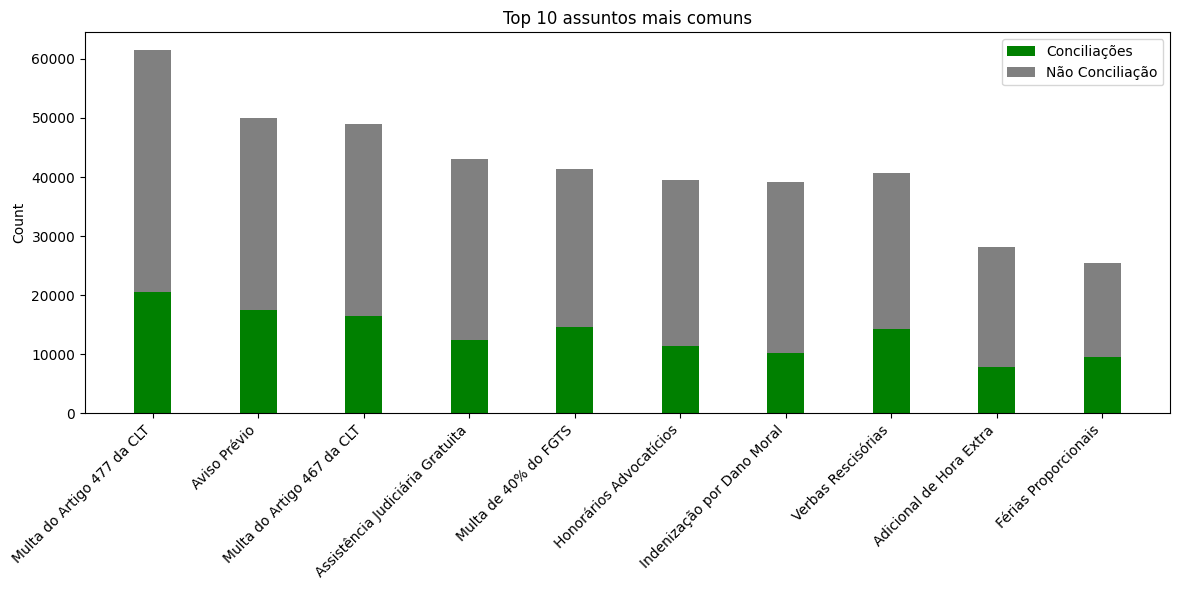

In [23]:
# Quais os assuntos mais presentes? E sua porcentagem de conciliação?
all_subjects = df['ASSUNTOS'].str.split(';').explode().str.strip()

top_10_subjects = all_subjects.value_counts().head(10)

plt.figure(figsize=(12, 6))

# For each subject, calculate total count and conciliation count
conciliation_data = []
total_data = []

for subject in top_10_subjects.index:
    # Get all processes containing this subject
    mask = df['ASSUNTOS'].str.contains(subject, na=False)
    total = mask.sum()
    
    # Get conciliation cases for this subject
    conciliation = df[mask & (df['TIPO DE SOLUÇÃO'] == 'Conciliações')].shape[0]
    
    conciliation_data.append(conciliation)
    total_data.append(total - conciliation)

# Create bar plot
bar_width = 0.35
x = range(len(top_10_subjects))

plt.bar(x, conciliation_data, bar_width, label='Conciliações', color='green')
plt.bar(x, total_data, bar_width, bottom=conciliation_data, label='Não Conciliação', color='gray')

plt.xticks(x, top_10_subjects.index, rotation=45, ha='right')
plt.title('Top 10 assuntos mais comuns')
plt.ylabel('Count')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 assuntos mais comuns')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

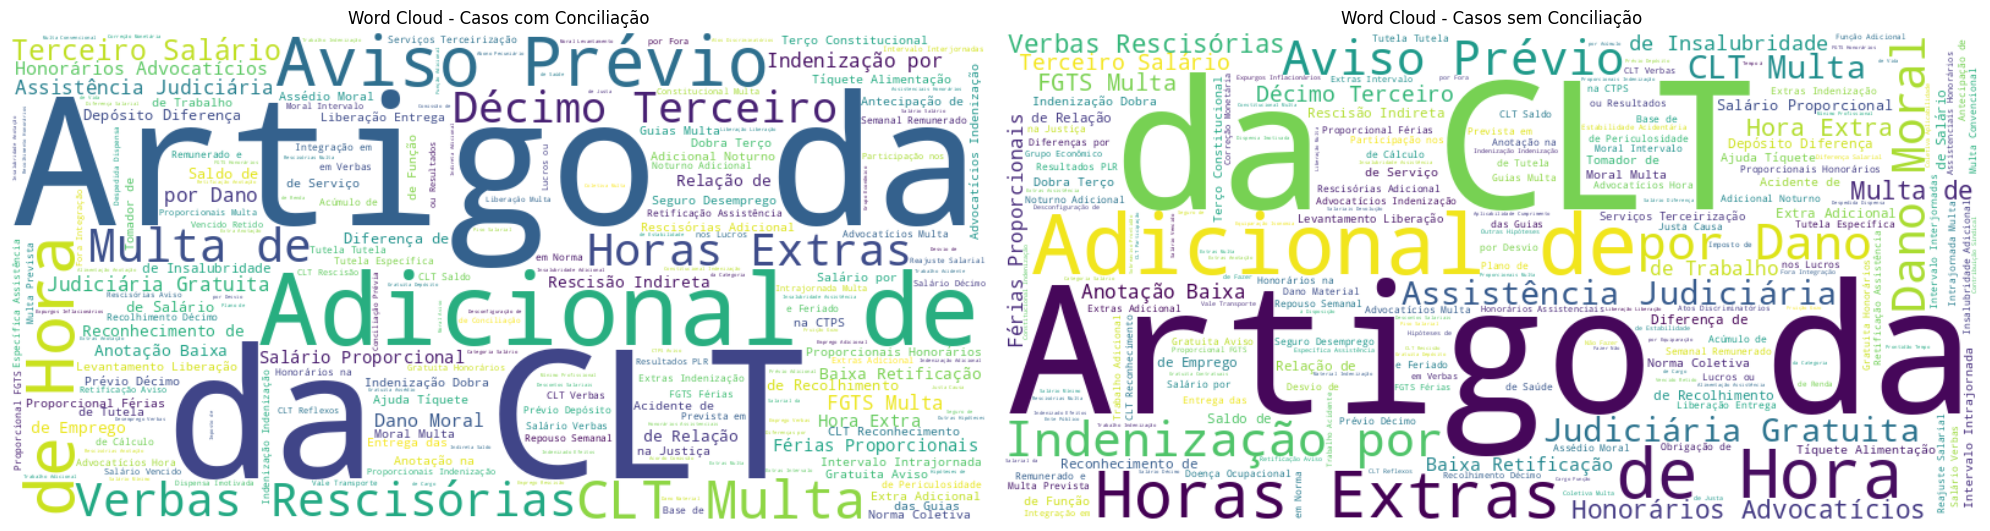

In [24]:
from wordcloud import WordCloud
# Separate texts for conciliation and non-conciliation cases
conciliation_text = ' '.join(df[df['TIPO DE SOLUÇÃO'] == 'Conciliações']['ASSUNTOS'].str.split(';').explode().str.strip())
non_conciliation_text = ' '.join(df[df['TIPO DE SOLUÇÃO'] != 'Conciliações']['ASSUNTOS'].str.split(';').explode().str.strip())

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Generate and display wordcloud for conciliation cases
wordcloud_conciliation = WordCloud(width=800, height=400, background_color='white').generate(conciliation_text)
ax1.imshow(wordcloud_conciliation, interpolation='bilinear')
ax1.axis('off')
ax1.set_title('Word Cloud - Casos com Conciliação')

# Generate and display wordcloud for non-conciliation cases
wordcloud_non_conciliation = WordCloud(width=800, height=400, background_color='white').generate(non_conciliation_text)
ax2.imshow(wordcloud_non_conciliation, interpolation='bilinear')
ax2.axis('off')
ax2.set_title('Word Cloud - Casos sem Conciliação')

plt.tight_layout()

In [25]:
import seaborn as sns

# Quais varas mais conciliam?

conciliation_by_vara = df.groupby('VARA DO TRABALHO').agg({
    'TIPO DE SOLUÇÃO': ['count', lambda x: (x == "Conciliações").sum()]
}).reset_index()

# Rename columns for clarity
conciliation_by_vara.columns = ['vara', 'total_processos', 'total_conciliados']

# Calculate percentage
conciliation_by_vara['percentual_conciliacao'] = (
    conciliation_by_vara['total_conciliados'] / conciliation_by_vara['total_processos'] * 100
)

# Sort by percentage in descending order
conciliation_by_vara = conciliation_by_vara.sort_values('percentual_conciliacao', ascending=False)
conciliation_by_vara[['vara', 'percentual_conciliacao']].head(10)

,vara,percentual_conciliacao
0,ALEV01 - Vara do Trabalho de Alegre ...,64.912281
10,NVEV01 - Vara do Trabalho de Nova Venécia ...,42.283298
12,PAALE - Posto Avançado de Alegre ...,41.911765
3,CITV02 - 2ª Vara do Trabalho de Cachoeiro ...,41.114482
11,PAAF - Posto Avançado de Afonso Cláudio ...,39.285714
2,CITV01 - 1ª Vara do Trabalho de Cachoeiro ...,39.222482
8,MATV01 - Vara do Trabalho de São Mateus ...,33.790200
5,GUAV01 - 1ª Vara do Trabalho de Guarapari ...,32.024766
1,ARAV01 - Vara do Trabalho de Aracruz ...,31.281198
13,PAMS - Posto Avançado de Mimoso do Sul ...,30.434783


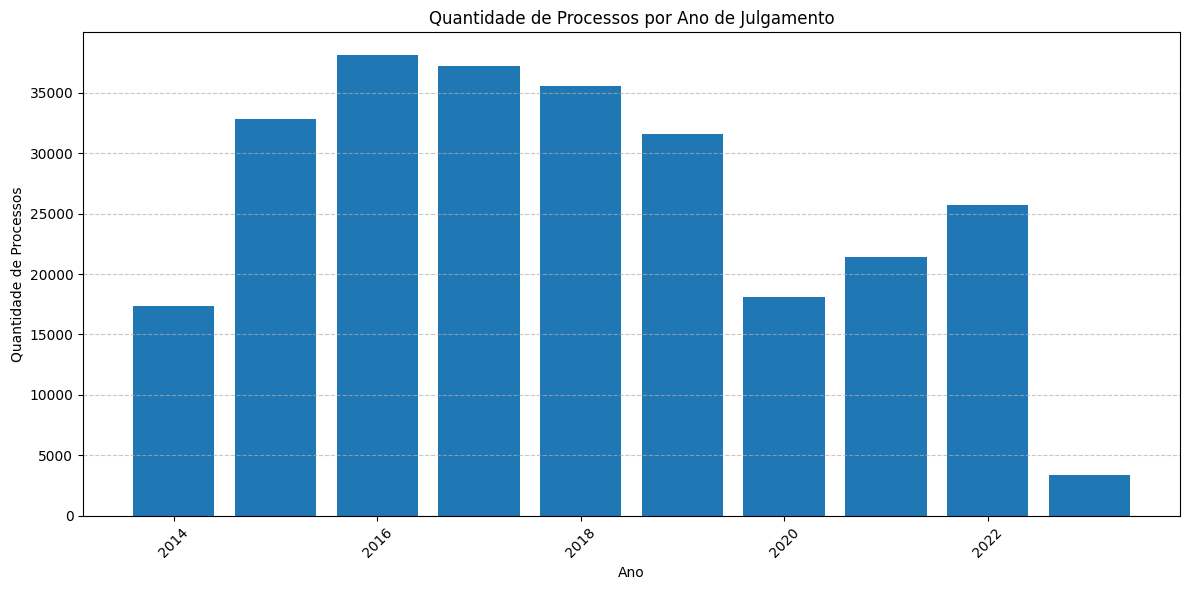

In [26]:
# Quantidade de processos por ano de data de julgamento
plt.figure(figsize=(12, 6))
df['ANO_JULGAMENTO'] = df['DATA DE JULGAMENTO'].dt.year
yearly_counts = df['ANO_JULGAMENTO'].value_counts().sort_index()

plt.bar(yearly_counts.index, yearly_counts.values)
plt.title('Quantidade de Processos por Ano de Julgamento')
plt.xlabel('Ano')
plt.ylabel('Quantidade de Processos')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Análise nas janelas móveis

In [27]:
import pandas as pd
import os

# Create empty list to store dataframes
dfs = []

# Read all window files
for i in range(20):  # Assuming there are windows from 0 to 19
    try:
        # Read the CSV file
        df = pd.read_parquet(f'../data/window_data/window_{i}/window_{i}.parquet.gzip')
        
        # Add window index as a column
        df['window_index'] = i
        
        # Append to list of dataframes
        dfs.append(df)
    except FileNotFoundError:
        print(f"File for window {i} not found, skipping...")
        continue

# Concatenate all windows
window_df = pd.concat(dfs, ignore_index=True)
window_df

File for window 19 not found, skipping...


,NÚMERO DO PROCESSO,CLASSE PROCESSUAL,VARA DO TRABALHO,MAGISTRADO,ASSUNTOS,PORTADOR DEFICIÊNCIA,SEGREDO DE JUSTIÇA,RECDA ATIVA-INATIVA,RECDA PES FÍS OU JUR,OAB,...,INDICADOR DO PROC,QTD RTE,QTD RDO,TIPO DE SOLUÇÃO,DATA DE JULGAMENTO,DATA DE AJUIZAMENTO,DOCUMENTOS DAS RECLAMADAS,DOCUMENTOS DOS RECLAMANTES,label,window_index
0,0000001-06.2015.5.17.0181,rtord - ação trabalhista - rito ordinário,nvev01 - vara trabalho nova venécia,GEOVANY CARDOSO JEVEAUX,anotação ctps; piso salarial categoria / salár...,n,n,s,"j, j",20625 - es,...,indicador proc,1.0,2.0,Conciliações,2015-03-17 18:53:28,2015-01-05 17:10:11.811,09.248.524/0001-70,136.033.447-58,1,0
1,0000001-22.2015.5.17.0014,rtord - ação trabalhista - rito ordinário,vitv14 - 14ª vara trabalho vitória,HELEN MABLE CARREÇO ALMEIDA RAMOS,multa prevista norma coletiva; norma coletiva ...,n,n,s,j,"21226 - es, 13406 - es, 23505 - es",...,indicador proc,1.0,1.0,Desistência,2015-03-26 14:11:00,2015-01-01 21:30:19.841,10.436.104/0001-05,28.164.150/0001-50,0,0
2,0000001-25.2015.5.17.0013,conpag - consignação pagamento,vitv13 - 13ª vara trabalho vitória,FAUSTO SIQUEIRA GAIA,morte,n,n,s,"f, f",56968 - mg,...,indicador proc,1.0,2.0,Extintos sem resolução de mérito,2015-02-05 06:28:24,2015-01-02 20:11:58.056,103.034.337-36,16.593.410/0001-23,0,0
3,0000001-28.2015.5.17.0012,rtord - ação trabalhista - rito ordinário,vitv12 - 12ª vara trabalho vitória,IVY D'LOURDES MALACARNE,assistência judiciária gratuita; honorários as...,n,n,s,"j, j","11011 - es, 30185 - es, 18839 - es, 17171 - es...",...,indicador proc,1.0,2.0,Desistência,2015-05-05 14:06:22,2015-01-05 12:50:56.712,17.469.701/0001-77|61.442.737/0001-59,30.978.340/0001-52,0,0
4,0000001-29.2015.5.17.0141,rtord - ação trabalhista - rito ordinário,colv01 - vara trabalho colatina,ADRIANA CORTELETTI PEREIRA CARDOSO,anotação / baixa / retificação; cargo confianç...,n,n,s,j,"9370 - es, 67356 - pr",...,indicador proc,1.0,1.0,Conciliações,2015-10-19 19:14:45,2015-01-08 10:17:08.535,79.540.670/0001-50,110.910.327-18,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989437,0001922-16.2016.5.17.0132,rtord - ação trabalhista - rito ordinário,citv02 - 2ª vara trabalho cachoeiro itapemirim,GIOVANNI ANTONIO DINIZ GUERRA,contrato suspenso,n,n,s,j,"8474 - es, 16583 - es, 7087 - es, 26185 - es, ...",...,indicador proc,1.0,1.0,Julgados Improcedente,2023-01-12 22:36:13,2016-12-06 15:51:58.663,27.193.705/0001-29,005.307.897-79,0,18
989438,0001985-58.2016.5.17.0191,rtord - ação trabalhista - rito ordinário,matv01 - vara trabalho mateus,EZEQUIEL ANDERSON,aviso prévio,n,n,s,"j, j, j, j, j","20844 - es, 229382 - sp, 13747 - es, 90070 - s...",...,indicador proc,1.0,5.0,Julgados Procedente em parte,2023-01-31 19:06:05,2016-12-15 11:50:32.428,39.403.274/0001-67|53.907.341/0001-01|15.019.5...,084.981.777-31,0,18
989439,0064100-29.2009.5.17.0008,rtord - ação trabalhista - rito ordinário,vitv08 - 8ª vara trabalho vitória,SILVANA DO EGITO BALBI,assistência judiciária gratuita; desconfiguraç...,n,n,s,j,"8390 - es, 92896 - rj, 6206 - es",...,indicador proc,1.0,1.0,Julgados Procedente,2023-02-02 12:41:14,2009-06-09 00:00:00.000,01.701.201/0001-89,804.457.997-49,0,18
989440,0124800-47.2013.5.17.0002,rtord - ação trabalhista - rito ordinário,vitv02 - 2ª vara trabalho vitória,HELEN MABLE CARREÇO ALMEIDA RAMOS,adicional hora extra; assistência judiciária g...,n,n,s,"f, j","4515 - es, 2468 - es",...,indicador proc,1.0,2.0,Julgados Procedente em parte,2023-02-13 09:45:39,2013-08-28 00:00:00.000,131.188.897-72|09.549.313/0001-78,037.519.097-02,0,18


<Figure size 1200x600 with 0 Axes>

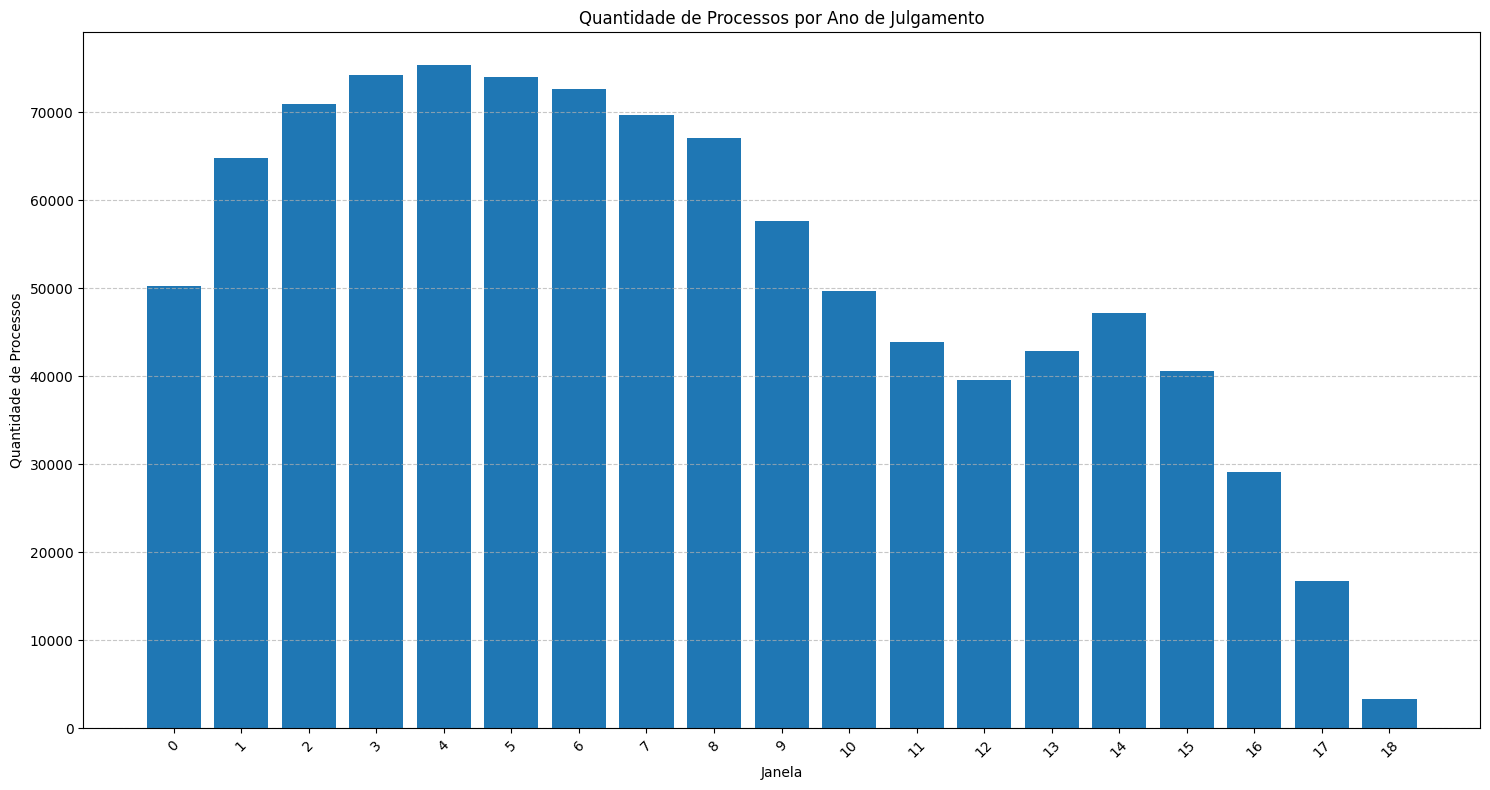

In [28]:
# Quantidade de processos por ano de data de julgamento
plt.figure(figsize=(12, 6))
df['ANO_JULGAMENTO'] = df['DATA DE JULGAMENTO'].dt.year
yearly_counts = df['ANO_JULGAMENTO'].value_counts().sort_index()

# Convert Convert window_index window_index to year to for year visualization for visualization
yearly_counts = window_df['window_index'].value_counts().sort_index()
window_df['window_index'].value_counts().sort_index()

plt.figure(figsize=(15, 8))
plt.bar(yearly_counts.index, yearly_counts.values)
plt.title('Quantidade de Processos por Ano de Julgamento')
plt.xlabel('Janela')
plt.ylabel('Quantidade de Processos')
plt.xticks(yearly_counts.index, yearly_counts.index, rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [29]:
# Quais as datas para cada janela?
# Group data to show start and end dates for each window
window_dates = window_df.groupby('window_index').agg({
    'DATA DE JULGAMENTO': ['min', 'max', 'count']
}).reset_index()

window_dates.columns = ['Janela', 'Data de Início', 'Data de Fim', 'Quantidade de Processos']
print("Datas para cada janela:")
print(window_dates.to_string(index=False))

Datas para cada janela:
 Janela      Data de Início         Data de Fim  Quantidade de Processos
      0 2014-01-06 22:40:55 2016-01-06 17:21:56                    50191
      1 2014-07-06 23:52:34 2016-07-06 21:34:37                    64740
      2 2015-01-06 22:44:27 2017-01-06 20:48:06                    70906
      3 2015-07-06 23:49:44 2017-07-06 22:11:41                    74254
      4 2016-01-06 22:43:23 2018-01-06 16:40:10                    75299
      5 2016-07-06 22:40:57 2018-07-06 18:11:55                    74010
      6 2017-01-06 22:41:12 2019-01-06 17:18:07                    72673
      7 2017-07-06 23:34:40 2019-07-06 19:23:47                    69700
      8 2018-01-07 18:36:10 2020-01-06 18:11:36                    67103
      9 2018-07-07 15:03:33 2020-07-06 20:55:08                    57664
     10 2019-01-07 08:43:30 2021-01-06 18:21:32                    49665
     11 2019-07-07 09:41:20 2021-07-06 20:36:23                    43841
     12 2020-01-07 09:43:30

# Metodologia

## Metodologia Clássica

```Loading dataset from data/updated_dataset.parquet.gzip
Processing column: VARA DO TRABALHO
Processing column: RAMO DE ATIVIDADE
Processing column: CLASSE PROCESSUAL
Processing column: CIDADE ORIG PET INICIAL
Processing column: OAB
Processing column: ASSUNTOS
Processing column: RECDA PES FÍS OU JUR
Processing column: PORTADOR DEFICIÊNCIA
Processing column: SEGREDO DE JUSTIÇA
Processing column: RECDA ATIVA-INATIVA
Processing column: ENTE PUB OU PRIV
Processing column: INDICADOR DO PROC
Processing column: DOCUMENTOS DAS RECLAMADAS
Processing column: DOCUMENTOS DOS RECLAMANTES

Dataset after loading:
          NÚMERO DO PROCESSO  ... label
0  0000001-03.2016.5.17.0009  ...     0
1  0000001-04.2019.5.17.0007  ...     0
2  0000001-05.2017.5.17.0191  ...     0
3  0000001-05.2022.5.17.0005  ...     0
4  0000001-06.2015.5.17.0181  ...     1
5  0000001-06.2016.5.17.0008  ...     1
6  0000001-07.2019.5.17.0006  ...     1
7  0000001-08.2022.5.17.0004  ...     0
8  0000001-09.2016.5.17.0007  ...     0
9  0000001-10.2019.5.17.0005  ...     0

[10 rows x 23 columns]

Created 19 rolling windows.

Processing Window 1 (from 2014-01-06 to 2016-01-06):

Window Label Distribution:
label
0    35364
1    14827
Name: count, dtype: int64
Total samples in window: 50191
------------------------------
Applying Target Encoding...
Evaluating models for Window 1:

Label Distribution:
Training set:
label
0    24698
1    10435
Name: count, dtype: int64

Testing set:
label
0    10666
1     4392
Name: count, dtype: int64
------------------------------

Model: LogisticRegression
              precision    recall  f1-score   support

           0       0.73      0.94      0.82     10666
           1       0.51      0.15      0.23      4392

    accuracy                           0.71     15058
   macro avg       0.62      0.55      0.53     15058
weighted avg       0.67      0.71      0.65     15058

------------------------------

Model: RandomForest
              precision    recall  f1-score   support

           0       0.75      0.92      0.82     10666
           1       0.55      0.24      0.33      4392

    accuracy                           0.72     15058
   macro avg       0.65      0.58      0.58     15058
weighted avg       0.69      0.72      0.68     15058

------------------------------

Model: GradientBoosting
              precision    recall  f1-score   support

           0       0.75      0.91      0.82     10666
           1       0.56      0.26      0.36      4392

    accuracy                           0.72     15058
   macro avg       0.65      0.59      0.59     15058
weighted avg       0.69      0.72      0.69     15058

------------------------------

Processing Window 2 (from 2014-07-06 to 2016-07-06):

Window Label Distribution:
label
0    46008
1    18732
Name: count, dtype: int64
Total samples in window: 64740
------------------------------
Applying Target Encoding...
Evaluating models for Window 2:

Label Distribution:
Training set:
label
0    32290
1    13028
Name: count, dtype: int64

Testing set:
label
0    13718
1     5704
Name: count, dtype: int64
------------------------------

Model: LogisticRegression
              precision    recall  f1-score   support

           0       0.73      0.95      0.82     13718
           1       0.54      0.14      0.23      5704

    accuracy                           0.71     19422
   macro avg       0.63      0.55      0.53     19422
weighted avg       0.67      0.71      0.65     19422

------------------------------

Model: RandomForest
              precision    recall  f1-score   support

           0       0.74      0.93      0.83     13718
           1       0.59      0.23      0.33      5704

    accuracy                           0.73     19422
   macro avg       0.67      0.58      0.58     19422
weighted avg       0.70      0.73      0.68     19422

------------------------------

Model: GradientBoosting
              precision    recall  f1-score   support

           0       0.74      0.94      0.83     13718
           1       0.57      0.20      0.30      5704

    accuracy                           0.72     19422
   macro avg       0.66      0.57      0.56     19422
weighted avg       0.69      0.72      0.67     19422

------------------------------

Processing Window 3 (from 2015-01-06 to 2017-01-06):

Window Label Distribution:
label
0    50870
1    20036
Name: count, dtype: int64
Total samples in window: 70906
------------------------------
Applying Target Encoding...
Evaluating models for Window 3:

Label Distribution:
Training set:
label
0    35572
1    14062
Name: count, dtype: int64

Testing set:
label
0    15298
1     5974
Name: count, dtype: int64
------------------------------

Model: LogisticRegression
              precision    recall  f1-score   support

           0       0.74      0.95      0.83     15298
           1       0.56      0.16      0.25      5974

    accuracy                           0.73     21272
   macro avg       0.65      0.56      0.54     21272
weighted avg       0.69      0.73      0.67     21272

------------------------------

Model: RandomForest
              precision    recall  f1-score   support

           0       0.76      0.93      0.84     15298
           1       0.59      0.24      0.34      5974

    accuracy                           0.74     21272
   macro avg       0.67      0.59      0.59     21272
weighted avg       0.71      0.74      0.70     21272

------------------------------

Model: GradientBoosting
              precision    recall  f1-score   support

           0       0.76      0.94      0.84     15298
           1       0.58      0.23      0.32      5974

    accuracy                           0.74     21272
   macro avg       0.67      0.58      0.58     21272
weighted avg       0.71      0.74      0.69     21272

------------------------------

Processing Window 4 (from 2015-07-06 to 2017-07-06):

Window Label Distribution:
label
0    53601
1    20653
Name: count, dtype: int64
Total samples in window: 74254
------------------------------
Applying Target Encoding...
Evaluating models for Window 4:

Label Distribution:
Training set:
label
0    37440
1    14537
Name: count, dtype: int64

Testing set:
label
0    16161
1     6116
Name: count, dtype: int64
------------------------------

Model: LogisticRegression
              precision    recall  f1-score   support

           0       0.75      0.95      0.84     16161
           1       0.56      0.16      0.25      6116

    accuracy                           0.74     22277
   macro avg       0.66      0.56      0.55     22277
weighted avg       0.70      0.74      0.68     22277

------------------------------

Model: RandomForest
              precision    recall  f1-score   support

           0       0.77      0.93      0.84     16161
           1       0.59      0.26      0.36      6116

    accuracy                           0.75     22277
   macro avg       0.68      0.60      0.60     22277
weighted avg       0.72      0.75      0.71     22277

------------------------------

Model: GradientBoosting
              precision    recall  f1-score   support

           0       0.76      0.94      0.84     16161
           1       0.59      0.24      0.34      6116

    accuracy                           0.75     22277
   macro avg       0.68      0.59      0.59     22277
weighted avg       0.72      0.75      0.70     22277

------------------------------

Processing Window 5 (from 2016-01-06 to 2018-01-06):

Window Label Distribution:
label
0    54086
1    21213
Name: count, dtype: int64
Total samples in window: 75299
------------------------------
Applying Target Encoding...
Evaluating models for Window 5:

Label Distribution:
Training set:
label
0    37824
1    14885
Name: count, dtype: int64

Testing set:
label
0    16262
1     6328
Name: count, dtype: int64
------------------------------

Model: LogisticRegression
              precision    recall  f1-score   support

           0       0.75      0.95      0.84     16262
           1       0.58      0.17      0.27      6328

    accuracy                           0.73     22590
   macro avg       0.66      0.56      0.55     22590
weighted avg       0.70      0.73      0.68     22590

------------------------------

Model: RandomForest
              precision    recall  f1-score   support

           0       0.77      0.94      0.84     16262
           1       0.61      0.26      0.37      6328

    accuracy                           0.75     22590
   macro avg       0.69      0.60      0.61     22590
weighted avg       0.72      0.75      0.71     22590

------------------------------

Model: GradientBoosting
              precision    recall  f1-score   support

           0       0.76      0.94      0.84     16262
           1       0.60      0.23      0.33      6328

    accuracy                           0.74     22590
   macro avg       0.68      0.58      0.58     22590
weighted avg       0.71      0.74      0.70     22590

------------------------------

Processing Window 6 (from 2016-07-06 to 2018-07-06):

Window Label Distribution:
label
0    53601
1    20409
Name: count, dtype: int64
Total samples in window: 74010
------------------------------
Applying Target Encoding...
Evaluating models for Window 6:

Label Distribution:
Training set:
label
0    37607
1    14200
Name: count, dtype: int64

Testing set:
label
0    15994
1     6209
Name: count, dtype: int64
------------------------------

Model: LogisticRegression
              precision    recall  f1-score   support

           0       0.75      0.96      0.84     15994
           1       0.63      0.17      0.27      6209

    accuracy                           0.74     22203
   macro avg       0.69      0.57      0.56     22203
weighted avg       0.72      0.74      0.68     22203

------------------------------

Model: RandomForest
              precision    recall  f1-score   support

           0       0.77      0.94      0.85     15994
           1       0.64      0.27      0.38      6209

    accuracy                           0.75     22203
   macro avg       0.71      0.61      0.62     22203
weighted avg       0.73      0.75      0.72     22203

------------------------------

Model: GradientBoosting
              precision    recall  f1-score   support

           0       0.76      0.95      0.84     15994
           1       0.64      0.25      0.36      6209

    accuracy                           0.75     22203
   macro avg       0.70      0.60      0.60     22203
weighted avg       0.73      0.75      0.71     22203

------------------------------

Processing Window 7 (from 2017-01-06 to 2019-01-06):

Window Label Distribution:
label
0    53175
1    19498
Name: count, dtype: int64
Total samples in window: 72673
------------------------------
Applying Target Encoding...
Evaluating models for Window 7:

Label Distribution:
Training set:
label
0    37207
1    13664
Name: count, dtype: int64

Testing set:
label
0    15968
1     5834
Name: count, dtype: int64
------------------------------

Model: LogisticRegression
              precision    recall  f1-score   support

           0       0.76      0.96      0.85     15968
           1       0.61      0.16      0.25      5834

    accuracy                           0.75     21802
   macro avg       0.68      0.56      0.55     21802
weighted avg       0.72      0.75      0.69     21802

------------------------------

Model: RandomForest
              precision    recall  f1-score   support

           0       0.77      0.94      0.85     15968
           1       0.61      0.25      0.35      5834

    accuracy                           0.76     21802
   macro avg       0.69      0.59      0.60     21802
weighted avg       0.73      0.76      0.72     21802

------------------------------

Model: GradientBoosting
              precision    recall  f1-score   support

           0       0.77      0.95      0.85     15968
           1       0.62      0.24      0.35      5834

    accuracy                           0.76     21802
   macro avg       0.69      0.59      0.60     21802
weighted avg       0.73      0.76      0.72     21802

------------------------------

Processing Window 8 (from 2017-07-06 to 2019-07-06):

Window Label Distribution:
label
0    51377
1    18323
Name: count, dtype: int64
Total samples in window: 69700
------------------------------
Applying Target Encoding...
Evaluating models for Window 8:

Label Distribution:
Training set:
label
0    35892
1    12898
Name: count, dtype: int64

Testing set:
label
0    15485
1     5425
Name: count, dtype: int64
------------------------------

Model: LogisticRegression
              precision    recall  f1-score   support

           0       0.76      0.96      0.85     15485
           1       0.56      0.15      0.23      5425

    accuracy                           0.75     20910
   macro avg       0.66      0.55      0.54     20910
weighted avg       0.71      0.75      0.69     20910

------------------------------

Model: RandomForest
              precision    recall  f1-score   support

           0       0.78      0.94      0.86     15485
           1       0.62      0.26      0.37      5425

    accuracy                           0.77     20910
   macro avg       0.70      0.60      0.61     20910
weighted avg       0.74      0.77      0.73     20910

------------------------------

Model: GradientBoosting
              precision    recall  f1-score   support

           0       0.78      0.95      0.85     15485
           1       0.60      0.23      0.33      5425

    accuracy                           0.76     20910
   macro avg       0.69      0.59      0.59     20910
weighted avg       0.73      0.76      0.72     20910

------------------------------

Processing Window 9 (from 2018-01-07 to 2020-01-06):

Window Label Distribution:
label
0    49651
1    17452
Name: count, dtype: int64
Total samples in window: 67103
------------------------------
Applying Target Encoding...
Evaluating models for Window 9:

Label Distribution:
Training set:
label
0    34847
1    12125
Name: count, dtype: int64

Testing set:
label
0    14804
1     5327
Name: count, dtype: int64
------------------------------

Model: LogisticRegression
              precision    recall  f1-score   support

           0       0.76      0.96      0.85     14804
           1       0.60      0.18      0.27      5327

    accuracy                           0.75     20131
   macro avg       0.68      0.57      0.56     20131
weighted avg       0.72      0.75      0.70     20131

------------------------------

Model: RandomForest
              precision    recall  f1-score   support

           0       0.79      0.94      0.86     14804
           1       0.63      0.30      0.40      5327

    accuracy                           0.77     20131
   macro avg       0.71      0.62      0.63     20131
weighted avg       0.75      0.77      0.74     20131

------------------------------

Model: GradientBoosting
              precision    recall  f1-score   support

           0       0.78      0.95      0.85     14804
           1       0.62      0.24      0.35      5327

    accuracy                           0.76     20131
   macro avg       0.70      0.59      0.60     20131
weighted avg       0.73      0.76      0.72     20131

------------------------------

Processing Window 10 (from 2018-07-07 to 2020-07-06):

Window Label Distribution:
label
0    42423
1    15241
Name: count, dtype: int64
Total samples in window: 57664
------------------------------
Applying Target Encoding...
Evaluating models for Window 10:

Label Distribution:
Training set:
label
0    29678
1    10686
Name: count, dtype: int64

Testing set:
label
0    12745
1     4555
Name: count, dtype: int64
------------------------------

Model: LogisticRegression
              precision    recall  f1-score   support

           0       0.77      0.96      0.85     12745
           1       0.63      0.19      0.29      4555

    accuracy                           0.76     17300
   macro avg       0.70      0.57      0.57     17300
weighted avg       0.73      0.76      0.70     17300

------------------------------

Model: RandomForest
              precision    recall  f1-score   support

           0       0.79      0.94      0.86     12745
           1       0.65      0.32      0.43      4555

    accuracy                           0.78     17300
   macro avg       0.72      0.63      0.65     17300
weighted avg       0.76      0.78      0.75     17300

------------------------------

Model: GradientBoosting
              precision    recall  f1-score   support

           0       0.78      0.95      0.86     12745
           1       0.64      0.26      0.37      4555

    accuracy                           0.77     17300
   macro avg       0.71      0.60      0.61     17300
weighted avg       0.74      0.77      0.73     17300

------------------------------

Processing Window 11 (from 2019-01-07 to 2021-01-06):

Window Label Distribution:
label
0    35684
1    13981
Name: count, dtype: int64
Total samples in window: 49665
------------------------------
Applying Target Encoding...
Evaluating models for Window 11:

Label Distribution:
Training set:
label
0    24947
1     9818
Name: count, dtype: int64

Testing set:
label
0    10737
1     4163
Name: count, dtype: int64
------------------------------

Model: LogisticRegression
              precision    recall  f1-score   support

           0       0.76      0.96      0.85     10737
           1       0.65      0.22      0.33      4163

    accuracy                           0.75     14900
   macro avg       0.71      0.59      0.59     14900
weighted avg       0.73      0.75      0.70     14900

------------------------------

Model: RandomForest
              precision    recall  f1-score   support

           0       0.78      0.94      0.85     10737
           1       0.67      0.34      0.45      4163

    accuracy                           0.77     14900
   macro avg       0.73      0.64      0.65     14900
weighted avg       0.75      0.77      0.74     14900

------------------------------

Model: GradientBoosting
              precision    recall  f1-score   support

           0       0.78      0.94      0.85     10737
           1       0.66      0.32      0.43      4163

    accuracy                           0.76     14900
   macro avg       0.72      0.63      0.64     14900
weighted avg       0.74      0.76      0.73     14900

------------------------------

Processing Window 12 (from 2019-07-07 to 2021-07-06):

Window Label Distribution:
label
0    31162
1    12679
Name: count, dtype: int64
Total samples in window: 43841
------------------------------
Applying Target Encoding...
Evaluating models for Window 12:

Label Distribution:
Training set:
label
0    21814
1     8874
Name: count, dtype: int64

Testing set:
label
0    9348
1    3805
Name: count, dtype: int64
------------------------------

Model: LogisticRegression
              precision    recall  f1-score   support

           0       0.75      0.96      0.84      9348
           1       0.69      0.22      0.33      3805

    accuracy                           0.75     13153
   macro avg       0.72      0.59      0.59     13153
weighted avg       0.73      0.75      0.70     13153

------------------------------

Model: RandomForest
              precision    recall  f1-score   support

           0       0.78      0.95      0.85      9348
           1       0.72      0.34      0.46      3805

    accuracy                           0.77     13153
   macro avg       0.75      0.64      0.66     13153
weighted avg       0.76      0.77      0.74     13153

------------------------------

Model: GradientBoosting
              precision    recall  f1-score   support

           0       0.77      0.95      0.85      9348
           1       0.69      0.29      0.41      3805

    accuracy                           0.76     13153
   macro avg       0.73      0.62      0.63     13153
weighted avg       0.75      0.76      0.72     13153

------------------------------

Processing Window 13 (from 2020-01-07 to 2022-01-06):

Window Label Distribution:
label
0    28301
1    11232
Name: count, dtype: int64
Total samples in window: 39533
------------------------------
Applying Target Encoding...
Evaluating models for Window 13:

Label Distribution:
Training set:
label
0    19811
1     7862
Name: count, dtype: int64

Testing set:
label
0    8490
1    3370
Name: count, dtype: int64
------------------------------

Model: LogisticRegression
              precision    recall  f1-score   support

           0       0.76      0.96      0.85      8490
           1       0.68      0.23      0.34      3370

    accuracy                           0.75     11860
   macro avg       0.72      0.59      0.59     11860
weighted avg       0.74      0.75      0.70     11860

------------------------------

Model: RandomForest
              precision    recall  f1-score   support

           0       0.78      0.95      0.85      8490
           1       0.70      0.31      0.43      3370

    accuracy                           0.77     11860
   macro avg       0.74      0.63      0.64     11860
weighted avg       0.75      0.77      0.73     11860

------------------------------

Model: GradientBoosting
              precision    recall  f1-score   support

           0       0.77      0.95      0.85      8490
           1       0.69      0.28      0.40      3370

    accuracy                           0.76     11860
   macro avg       0.73      0.62      0.63     11860
weighted avg       0.75      0.76      0.72     11860

------------------------------

Processing Window 14 (from 2020-07-07 to 2022-07-06):

Window Label Distribution:
label
0    30986
1    11839
Name: count, dtype: int64
Total samples in window: 42825
------------------------------
Applying Target Encoding...
Evaluating models for Window 14:

Label Distribution:
Training set:
label
0    21644
1     8333
Name: count, dtype: int64

Testing set:
label
0    9342
1    3506
Name: count, dtype: int64
------------------------------

Model: LogisticRegression
              precision    recall  f1-score   support

           0       0.76      0.96      0.85      9342
           1       0.65      0.21      0.32      3506

    accuracy                           0.75     12848
   macro avg       0.71      0.59      0.59     12848
weighted avg       0.73      0.75      0.71     12848

------------------------------

Model: RandomForest
              precision    recall  f1-score   support

           0       0.78      0.94      0.85      9342
           1       0.66      0.30      0.41      3506

    accuracy                           0.77     12848
   macro avg       0.72      0.62      0.63     12848
weighted avg       0.75      0.77      0.73     12848

------------------------------

Model: GradientBoosting
              precision    recall  f1-score   support

           0       0.77      0.95      0.85      9342
           1       0.65      0.25      0.36      3506

    accuracy                           0.76     12848
   macro avg       0.71      0.60      0.61     12848
weighted avg       0.74      0.76      0.72     12848

------------------------------

Processing Window 15 (from 2021-01-07 to 2023-01-06):

Window Label Distribution:
label
0    35719
1    11502
Name: count, dtype: int64
Total samples in window: 47221
------------------------------
Applying Target Encoding...
Evaluating models for Window 15:

Label Distribution:
Training set:
label
0    24998
1     8056
Name: count, dtype: int64

Testing set:
label
0    10721
1     3446
Name: count, dtype: int64
------------------------------

Model: LogisticRegression
              precision    recall  f1-score   support

           0       0.79      0.96      0.87     10721
           1       0.64      0.20      0.31      3446

    accuracy                           0.78     14167
   macro avg       0.72      0.58      0.59     14167
weighted avg       0.75      0.78      0.73     14167

------------------------------

Model: RandomForest
              precision    recall  f1-score   support

           0       0.80      0.96      0.87     10721
           1       0.64      0.25      0.36      3446

    accuracy                           0.78     14167
   macro avg       0.72      0.60      0.62     14167
weighted avg       0.76      0.78      0.75     14167

------------------------------

Model: GradientBoosting
              precision    recall  f1-score   support

           0       0.80      0.96      0.87     10721
           1       0.64      0.24      0.35      3446

    accuracy                           0.78     14167
   macro avg       0.72      0.60      0.61     14167
weighted avg       0.76      0.78      0.74     14167

------------------------------

Processing Window 16 (from 2021-07-06 to 2023-02-28):

Window Label Distribution:
label
0    31044
1     9541
Name: count, dtype: int64
Total samples in window: 40585
------------------------------
Applying Target Encoding...
Evaluating models for Window 16:

Label Distribution:
Training set:
label
0    21736
1     6673
Name: count, dtype: int64

Testing set:
label
0    9308
1    2868
Name: count, dtype: int64
------------------------------

Model: LogisticRegression
              precision    recall  f1-score   support

           0       0.80      0.97      0.87      9308
           1       0.66      0.20      0.30      2868

    accuracy                           0.79     12176
   macro avg       0.73      0.58      0.59     12176
weighted avg       0.76      0.79      0.74     12176

------------------------------

Model: RandomForest
              precision    recall  f1-score   support

           0       0.81      0.96      0.88      9308
           1       0.65      0.25      0.36      2868

    accuracy                           0.79     12176
   macro avg       0.73      0.60      0.62     12176
weighted avg       0.77      0.79      0.75     12176

------------------------------

Model: GradientBoosting
              precision    recall  f1-score   support

           0       0.80      0.96      0.87      9308
           1       0.64      0.23      0.34      2868

    accuracy                           0.79     12176
   macro avg       0.72      0.59      0.60     12176
weighted avg       0.76      0.79      0.75     12176

------------------------------

Processing Window 17 (from 2022-01-07 to 2023-02-28):

Window Label Distribution:
label
0    22662
1     6456
Name: count, dtype: int64
Total samples in window: 29118
------------------------------
Applying Target Encoding...
Evaluating models for Window 17:

Label Distribution:
Training set:
label
0    15844
1     4538
Name: count, dtype: int64

Testing set:
label
0    6818
1    1918
Name: count, dtype: int64
------------------------------

Model: LogisticRegression
              precision    recall  f1-score   support

           0       0.81      0.97      0.88      6818
           1       0.60      0.17      0.26      1918

    accuracy                           0.79      8736
   macro avg       0.70      0.57      0.57      8736
weighted avg       0.76      0.79      0.74      8736

------------------------------

Model: RandomForest
              precision    recall  f1-score   support

           0       0.82      0.96      0.88      6818
           1       0.63      0.23      0.33      1918

    accuracy                           0.80      8736
   macro avg       0.72      0.59      0.61      8736
weighted avg       0.77      0.80      0.76      8736

------------------------------

Model: GradientBoosting
              precision    recall  f1-score   support

           0       0.81      0.97      0.88      6818
           1       0.62      0.20      0.30      1918

    accuracy                           0.80      8736
   macro avg       0.72      0.58      0.59      8736
weighted avg       0.77      0.80      0.76      8736

------------------------------

Processing Window 18 (from 2022-07-07 to 2023-02-28):

Window Label Distribution:
label
0    13392
1     3355
Name: count, dtype: int64
Total samples in window: 16747
------------------------------
Applying Target Encoding...
Evaluating models for Window 18:

Label Distribution:
Training set:
label
0    9405
1    2317
Name: count, dtype: int64

Testing set:
label
0    3987
1    1038
Name: count, dtype: int64
------------------------------

Model: LogisticRegression
              precision    recall  f1-score   support

           0       0.82      0.98      0.89      3987
           1       0.63      0.16      0.26      1038

    accuracy                           0.81      5025
   macro avg       0.73      0.57      0.57      5025
weighted avg       0.78      0.81      0.76      5025

------------------------------

Model: RandomForest
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      3987
           1       0.62      0.19      0.29      1038

    accuracy                           0.81      5025
   macro avg       0.72      0.58      0.59      5025
weighted avg       0.78      0.81      0.77      5025

------------------------------

Model: GradientBoosting
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      3987
           1       0.59      0.17      0.26      1038

    accuracy                           0.80      5025
   macro avg       0.70      0.57      0.57      5025
weighted avg       0.77      0.80      0.76      5025

------------------------------

Processing Window 19 (from 2023-01-08 to 2023-02-28):

Window Label Distribution:
label
0    2758
1     609
Name: count, dtype: int64
Total samples in window: 3367
------------------------------
Applying Target Encoding...
Evaluating models for Window 19:

Label Distribution:
Training set:
label
0    1923
1     433
Name: count, dtype: int64

Testing set:
label
0    835
1    176
Name: count, dtype: int64
------------------------------

Model: LogisticRegression
              precision    recall  f1-score   support

           0       0.85      0.99      0.91       835
           1       0.80      0.14      0.23       176

    accuracy                           0.84      1011
   macro avg       0.82      0.56      0.57      1011
weighted avg       0.84      0.84      0.79      1011

------------------------------

Model: RandomForest
              precision    recall  f1-score   support

           0       0.84      0.98      0.91       835
           1       0.63      0.14      0.22       176

    accuracy                           0.84      1011
   macro avg       0.74      0.56      0.57      1011
weighted avg       0.81      0.84      0.79      1011

------------------------------

Model: GradientBoosting
              precision    recall  f1-score   support

           0       0.85      0.93      0.89       835
           1       0.39      0.22      0.28       176

    accuracy                           0.80      1011
   macro avg       0.62      0.57      0.58      1011
weighted avg       0.77      0.80      0.78      1011

------------------------------

Results saved to classical_analysis/results/window_classification_results.csv```

# Resultados

In [30]:
# Resultados metodologia classica
df_results_classic = pd.read_csv('../classical_analysis/results/window_classification_results.csv')
df_results_classic

,window_number,start_date,end_date,model,accuracy,macro_avg_precision,macro_avg_recall,macro_avg_f1,weighted_avg_precision,weighted_avg_recall,weighted_avg_f1
0,1,2014-01-06,2016-01-06,LogisticRegression,0.710254,0.620035,0.545222,0.526211,0.665332,0.710254,0.649246
1,1,2014-01-06,2016-01-06,RandomForest,0.721809,0.649777,0.579897,0.579152,0.689913,0.721809,0.681243
2,1,2014-01-06,2016-01-06,GradientBoosting,0.724399,0.654687,0.588489,0.590801,0.694688,0.724399,0.688220
3,2,2014-07-06,2016-07-06,LogisticRegression,0.712645,0.633870,0.546526,0.525416,0.672402,0.712645,0.648414
4,2,2014-07-06,2016-07-06,RandomForest,0.726393,0.666578,0.580019,0.577168,0.698404,0.726393,0.680816
5,2,2014-07-06,2016-07-06,GradientBoosting,0.721604,0.656539,0.569306,0.561704,0.690293,0.721604,0.670939
6,3,2015-01-06,2017-01-06,LogisticRegression,0.729598,0.654327,0.556789,0.543677,0.693684,0.729598,0.671349
7,3,2015-01-06,2017-01-06,RandomForest,0.738530,0.671781,0.585444,0.586886,0.709610,0.738530,0.696595
8,3,2015-01-06,2017-01-06,GradientBoosting,0.736367,0.667181,0.580676,0.580362,0.706004,0.736367,0.692513
9,4,2015-07-06,2017-07-06,LogisticRegression,0.735467,0.656804,0.557256,0.545509,0.698926,0.735467,0.678000


In [31]:
# Resultados metodologia classica
df_results_llm_embedding = pd.read_csv('../llm_analysis/results/embedding/results_summary_random_forest.csv')
df_results_llm_embedding

,accuracy,precision,recall,f1,window
0,0.734228,0.701001,0.571788,0.561058,0
1,0.738595,0.723980,0.577750,0.568182,1
2,0.749436,0.726409,0.578692,0.572637,2
3,0.755533,0.730615,0.580029,0.575953,3
4,0.751616,0.725697,0.583779,0.580766,4
5,0.756745,0.747481,0.587237,0.584890,5
6,0.762224,0.740866,0.578933,0.575298,6
7,0.770062,0.735660,0.585727,0.587813,7
8,0.775868,0.760408,0.602635,0.610416,8
9,0.786012,0.774606,0.621284,0.635908,9


In [32]:
# 1. Selecionar apenas as colunas de interesse do modelo clássico
df_results_classic = df_results_classic[[
    "window_number",
    "model",
    "macro_avg_precision",
    "macro_avg_recall",
    "macro_avg_f1"
]]

df_results_classic['window_number'] = df_results_classic['window_number'] - 1

# 2. Renomear as colunas se quiser diferenciá-las (opcional)
df_results_classic = df_results_classic.rename(
    columns={
        "macro_avg_precision": "macro_precision",
        "macro_avg_recall": "macro_recall",
        "macro_avg_f1": "macro_f1",
        "window_number": "window"
    }
)

# 3. Fazer o merge relacionando 'window' (df1) com 'window_number' (df2)
df_results_llm_embedding = df_results_llm_embedding.rename(
    columns={
        "precision": "macro_precision",
        "recall": "macro_recall",
        "f1": "macro_f1"
    }
)

# 3. Fazer o merge relacionando 'window' (df1) com 'window_number' (df2)
df_results_llm_embedding['model'] = 'LLM_Embedding'

# 4. Concatenar os resultados
df_results = pd.concat([df_results_classic, df_results_llm_embedding], ignore_index=True)
df_results = df_results.sort_values(
    by=['window', 'model'], 
    ascending=[True, False]
)
df_results

/tmp/ipykernel_301132/3824041459.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results_classic['window_number'] = df_results_classic['window_number'] - 1


,window,model,macro_precision,macro_recall,macro_f1,accuracy
1,0,RandomForest,0.649777,0.579897,0.579152,NaN
0,0,LogisticRegression,0.620035,0.545222,0.526211,NaN
57,0,LLM_Embedding,0.701001,0.571788,0.561058,0.734228
2,0,GradientBoosting,0.654687,0.588489,0.590801,NaN
4,1,RandomForest,0.666578,0.580019,0.577168,NaN
...,...,...,...,...,...,...
53,17,GradientBoosting,0.702116,0.569228,0.574951,NaN
55,18,RandomForest,0.737681,0.559799,0.566242,NaN
54,18,LogisticRegression,0.822528,0.564589,0.573003,NaN
75,18,LLM_Embedding,0.826185,0.567430,0.577522,0.844708


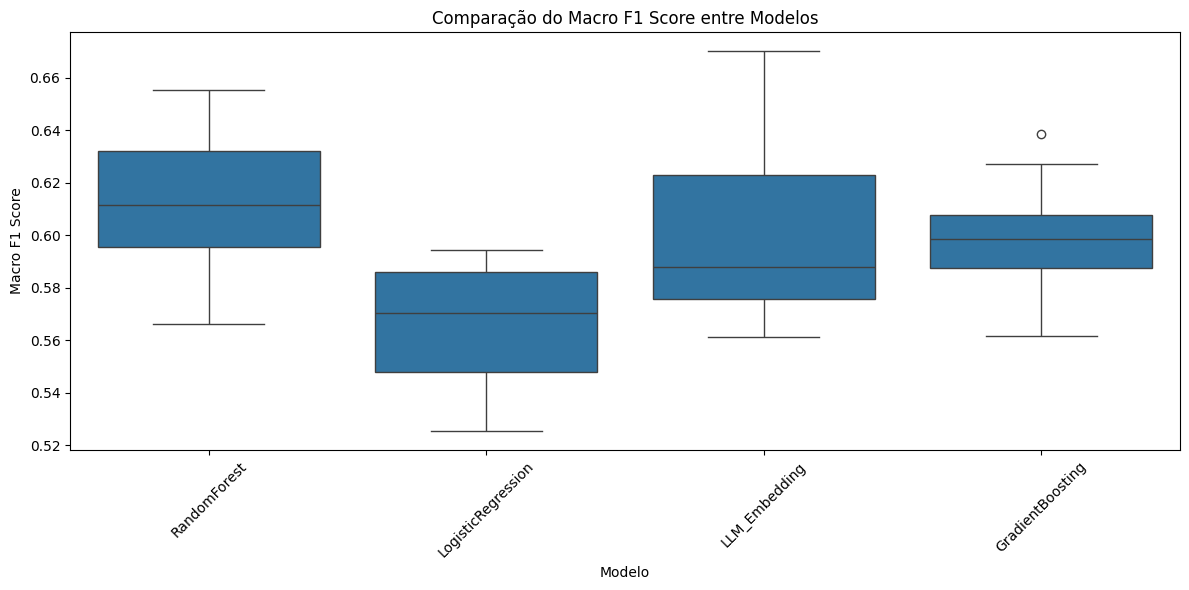

In [33]:
# Create box plot for macro F1 scores
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_results, x='model', y='macro_f1')

# Customize the plot
plt.title('Comparação do Macro F1 Score entre Modelos')
plt.xlabel('Modelo')
plt.ylabel('Macro F1 Score')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

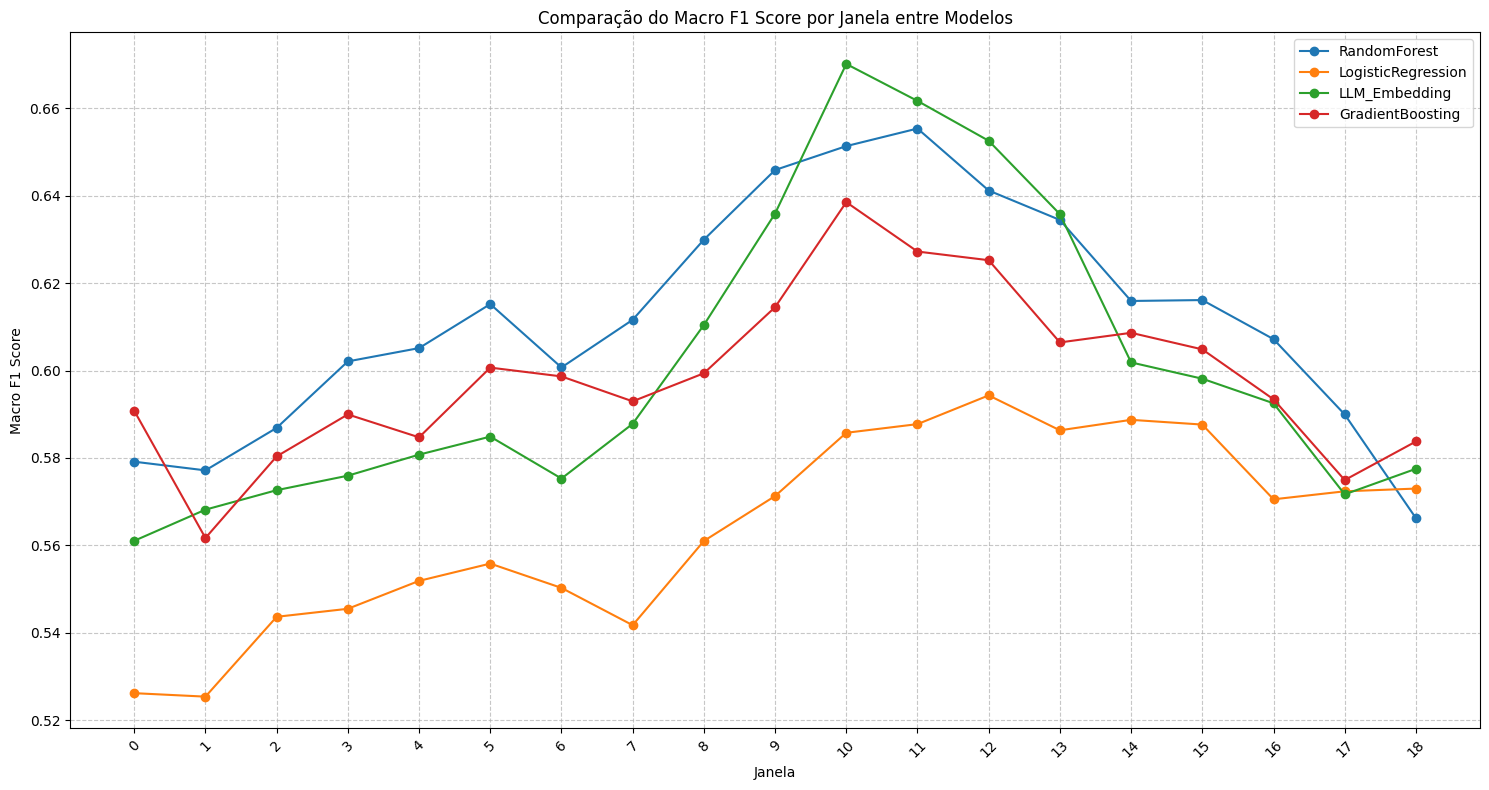

In [34]:
# Create line plot
plt.figure(figsize=(15, 8))

# Plot lines for each model
for model in df_results['model'].unique():
    model_data = df_results[df_results['model'] == model]
    plt.plot(model_data['window'], model_data['macro_f1'], marker='o', label=model)

# Customize the plot
plt.title('Comparação do Macro F1 Score por Janela entre Modelos')
plt.xlabel('Janela')
plt.ylabel('Macro F1 Score')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Set x-axis ticks to show all windows
plt.xticks(df_results['window'].unique())

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

# Conclusões e discussões